### Импорт библиотек и загрузка файлов

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv1D, Flatten, Dense, Dropout, RepeatVector
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from transformers import BertConfig, TFBertModel

from modules.data_transformation import *
from modules.model_evaluation import (evaluate_regression_model, evaluate_classification_model, plot_learning_curves)

In [27]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

### MMgRNA dataset

In [34]:
df = pd.read_csv(r"data/Table_S8_machine_learning_input.csv", engine="python", sep='\t')

In [35]:
df.rename(columns={
    "perfect match sgRNA": "perfect_match_sgRNA",
    "sgRNA sequence": "sgRNA_sequence",
    "mismatch position": "mismatch_position",
    "new pairing": "new_pairing",
    "mean relative gamma": "mean_relative_gamma",
    "genome input": "genome_input",
    "sgRNA input": "sgRNA_input"
}, inplace=True)

In [36]:
# df['encoded_or'] = df.apply(
#     lambda row: encode_or(
#         row['genome_input'],
#         row['sgRNA_input']
#     ).flatten(),
#     axis=1
# )

df['encoded_7channels'] = df.apply(
    lambda row: encode_7channels_mmrna(
        row['genome_input'],
        row['sgRNA_input']
    ).flatten(),
    axis=1
)

df['mismatch_count'] = df.apply(
    lambda row: count_mismatches(row['genome_input'], row['sgRNA_input']),
    axis=1
)

df['gc_genome'] = df['genome_input'].apply(calc_gc_content)
df['gc_sgrna'] = df['sgRNA_input'].apply(calc_gc_content)

df['pam'] = df['sgRNA_input'].apply(pam_mmrna)

### Generating CRISPR-BERT Embeddings

In [40]:
# Словарь кодировки пар оснований
base_pair_dict = {
    "AA": 2, "AC": 3, "AG": 4, "AT": 5,
    "CA": 6, "CC": 7, "CG": 8, "CT": 9,
    "GA": 10, "GC": 11, "GG": 12, "GT": 13,
    "TA": 14, "TC": 15, "TG": 16, "TT": 17,
    "A_": 18, "_A": 19, "C_": 20, "_C": 21,
    "G_": 22, "_G": 23, "T_": 24, "_T": 25
}

def BERT_encode(sequence_pairs, max_length=26):
    """
    Кодирует список sgRNA-ДНК пар в числовые последовательности для подачи в BERT.
    
    :param sequence_pairs: список кортежей (sgRNA, DNA)
    :param max_length: максимальная длина последовательности (например, 26)
    :return: numpy массивы с токенами и позиционной информацией
    """
    encoded_sequences = []
    
    for sgRNA, DNA in sequence_pairs:
        assert len(sgRNA) == len(DNA), "Длины sgRNA и DNA должны совпадать"
        
        tokens = [0]  # [CLS] в начале
        for r, d in zip(sgRNA, DNA):
            pair = r + d
            tokens.append(base_pair_dict.get(pair, 1))  # 1 - если неизвестная пара
        tokens.append(1)  # [SEP] в конце

        # Дополнение до max_length
        while len(tokens) < max_length:
            tokens.append(0)  # [PAD]
        
        encoded_sequences.append(tokens[:max_length])  # Обрезка, если больше max_length

    return np.array(encoded_sequences, dtype=np.int32)

In [ ]:
checkpoint_path = r"./weight/bert_weight/uncased_L-2_H-256_A-4/bert_model.ckpt"
checkpoint = tf.train.Checkpoint()
checkpoint.restore(checkpoint_path).expect_partial()

print("Модель успешно загружена!")

Модель успешно загружена!


In [ ]:
config_path = r"./weight/bert_weight/uncased_L-2_H-256_A-4/bert_config.json"
config = BertConfig.from_json_file(config_path)

print("✅ Конфигурация загружена!")

✅ Конфигурация загружена!


In [ ]:
bert_model = TFBertModel(config)
print("✅ BERT-модель создана!")

✅ BERT-модель создана!


In [47]:
checkpoint_path = r"./weight/bert_weight/uncased_L-2_H-256_A-4/bert_model.ckpt"
bert_model.load_weights(checkpoint_path)

print("✅ Веса загружены в BERT!")


✅ Веса загружены в BERT!


In [ ]:
# Создание списка пар sgRNA-ДНК
sequence_pairs = list(zip(df["sgRNA_input"], df["genome_input"]))

# Кодируем последовательности
bert_inputs = BERT_encode(sequence_pairs, max_length=26)

# Преобразуем в нужный формат
bert_inputs = np.array(bert_inputs)

# Генерация маски (1 для токенов, 0 для паддингов)
attention_mask = np.where(bert_inputs != 0, 1, 0)

# Передача в BERT
bert_outputs = bert_model.predict([bert_inputs, attention_mask])

# Усредняем эмбеддинги по токенам
bert_embeddings = np.mean(bert_outputs.last_hidden_state, axis=1)

print("✅ BERT эмбеддинги получены!", bert_embeddings.shape)

821/821 [==============================] - 47s 42ms/step
✅ BERT эмбеддинги получены! (26248, 256)


### MLP

In [53]:
# Разделяем данные
X_train, X_test, y_train, y_test = train_test_split(bert_embeddings, df["mean_relative_gamma"].values, test_size=0.2, random_state=42)

print(f"✅ Данные готовы! X_train: {X_train.shape}, y_train: {y_train.shape}")

✅ Данные готовы! X_train: (20998, 256), y_train: (20998,)


In [54]:
# Создаем модель
model = Sequential([
    Dense(128, activation="relu", input_shape=(256,)),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(1, activation="linear")  # Регрессия
])

# Компиляция модели
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Вывод структуры
model.summary()

d:\polina\CRISPR\crispr\crispr-bert\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,265 (169.00 KB)

 Trainable params: 43,265 (169.00 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
# Обучение модели
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30, batch_size=32,
    verbose=1
)

Epoch 1/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1667 - mae: 0.3338 - val_loss: 0.1546 - val_mae: 0.3111
Epoch 2/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1503 - mae: 0.3249 - val_loss: 0.1500 - val_mae: 0.3291
Epoch 3/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1482 - mae: 0.3245 - val_loss: 0.1493 - val_mae: 0.3339
Epoch 4/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1477 - mae: 0.3246 - val_loss: 0.1491 - val_mae: 0.3270
Epoch 5/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1488 - mae: 0.3268 - val_loss: 0.1519 - val_mae: 0.3240
Epoch 6/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1487 - mae: 0.3256 - val_loss: 0.1510 - val_mae: 0.3431
Epoch 7/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1488 - mae: 0.3253 - val_loss: 0.1479 - val_mae: 0.3212
Epoch 8/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1493 - mae: 0.3262 - val_loss: 0.1503 - val_mae: 0.3180
Epoch 9/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lo

In [57]:
results_df, mse, mae, r2 = evaluate_regression_model(model, X_test, y_test)

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1470 - mae: 0.3215
Test Loss (MSE): 0.14490
Test MAE: 0.31908
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Regression Metrics:
Mean Squared Error (MSE): 0.14490
Mean Absolute Error (MAE): 0.31908
R² Score: 0.05011


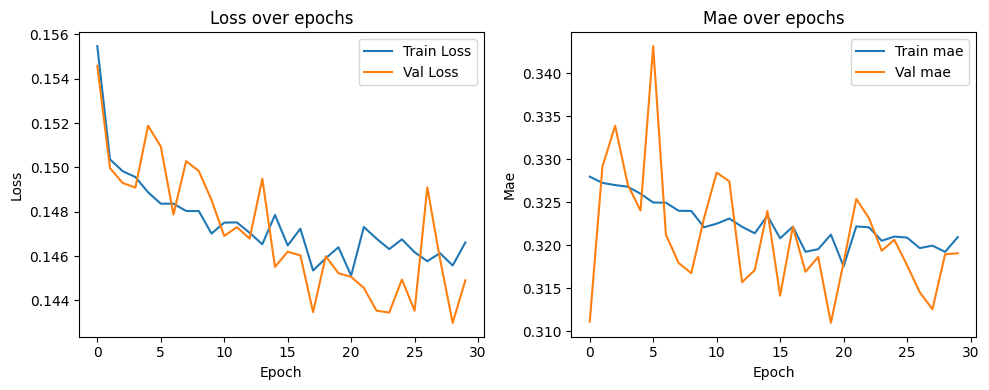

In [ ]:
plot_learning_curves(history, metric='mae')

### CNN

In [ ]:
# Преобразуем эмбеддинги BERT для подачи в Conv1D
X_reshaped = np.expand_dims(bert_embeddings, axis=-1)  # (samples, 256, 1)

# Разделяем данные
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, df["mean_relative_gamma"].values, test_size=0.2, random_state=42)

print(f"✅ Данные готовы! X_train: {X_train.shape}, y_train: {y_train.shape}")

✅ Данные готовы! X_train: (20998, 256, 1), y_train: (20998,)


In [ ]:
# Входной слой
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# Сверточный слой
x = Conv1D(32, kernel_size=3, activation='relu', padding='same')(input_layer)
x = Flatten()(x)  # Преобразуем в одномерный вектор
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)

# Выходной слой (регрессия)
output_layer = Dense(1, activation='linear')(x)

# Определяем модель
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # MSE + MAE

# Вывод структуры модели
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 256, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 526,593 (2.01 MB)

 Trainable params: 526,593 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
# Обучение модели
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30, batch_size=32,
    verbose=1
)

Epoch 1/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.1740 - mae: 0.3304 - val_loss: 0.1526 - val_mae: 0.3308
Epoch 2/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.1526 - mae: 0.3307 - val_loss: 0.1526 - val_mae: 0.3326
Epoch 3/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.1519 - mae: 0.3304 - val_loss: 0.1530 - val_mae: 0.3389
Epoch 4/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.1508 - mae: 0.3302 - val_loss: 0.1527 - val_mae: 0.3279
Epoch 5/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.1510 - mae: 0.3285 - val_loss: 0.1525 - val_mae: 0.3324
Epoch 6/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.1523 - mae: 0.3326 - val_loss: 0.1526 - val_mae: 0.3327
Epoch 7/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1511 - mae: 0.3298 - val_loss: 0.1526 - val_mae: 0.3310
Epoch 8/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1506 - mae: 0.3285 - val_loss: 0.1529 - val_mae: 0.3383
Epoch 9/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step -

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1550 - mae: 0.3348
Test Loss (MSE): 0.15255
Test MAE: 0.33193
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step

Regression Metrics:
Mean Squared Error (MSE): 0.15255
Mean Absolute Error (MAE): 0.33193
R² Score: -0.00000


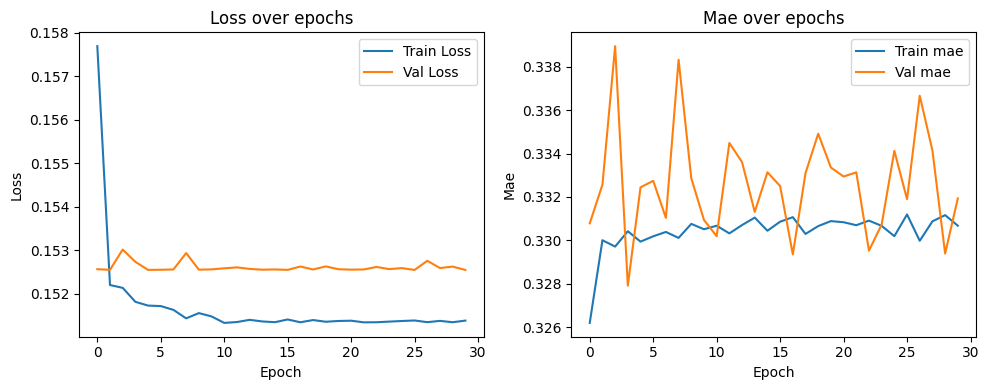

In [63]:
results_df, mse, mae, r2 = evaluate_regression_model(model, X_test, y_test)
plot_learning_curves(history, metric='mae')

### CRISPR-BERT architecture

In [76]:
# BERT-эмбеддинги (размер: samples, 256)
X_bert = bert_embeddings

# 7-канальная кодировка (размер: samples, 26, 7)
# ✅ Преобразуем список массивов в корректный numpy-массив (26, 7)
X_encoded = np.array([x.reshape(26, 7) for x in df["encoded_7channels"].values])

# Целевая переменная
y = df["mean_relative_gamma"].values

# Разделение на train/test
X_bert_train, X_bert_test, X_enc_train, X_enc_test, y_train, y_test = train_test_split(
    X_bert, X_encoded, y, test_size=0.2, random_state=42
)

print(f"✅ Данные готовы! X_bert_train: {X_bert_train.shape}, X_enc_train: {X_enc_train.shape}, y_train: {y_train.shape}")

✅ Данные готовы! X_bert_train: (20998, 256), X_enc_train: (20998, 26, 7), y_train: (20998,)


In [ ]:
def build_crispr_regression():
    # Входы
    X_in = Input(shape=(26, 7))  # 7-канальная кодировка
    X_bert_in = Input(shape=(256,))  # BERT-эмбеддинги

    # CNN + BiGRU обработка 7-канальной кодировки
    x = Reshape((26, 7, 1))(X_in)
    conv_1 = Conv2D(5, (1, 1), padding="same", activation="relu")(x)
    conv_2 = Conv2D(15, (2, 2), padding="same", activation="relu")(x)
    conv_3 = Conv2D(25, (3, 3), padding="same", activation="relu")(x)
    conv_4 = Conv2D(35, (5, 5), padding="same", activation="relu")(x)
    conv_output = tf.keras.layers.concatenate([conv_1, conv_2, conv_3, conv_4])  # (26, 7, 80)

    # Корректное приведение формы
    conv_output = Flatten()(conv_output)  # (26 * 7 * 80,) = (14560,)
    conv_output = Dense(2080, activation="relu")(conv_output)  # Сжимаем
    conv_output = Reshape((26, 80))(conv_output)  # Теперь размер правильный
    conv_output = Bidirectional(GRU(40, return_sequences=True))(conv_output)

    # Обработка BERT-эмбеддингов
    x_bert = Dense(128, activation="relu")(X_bert_in)
    x_bert = Dropout(0.3)(x_bert)
    x_bert = Dense(64, activation="relu")(x_bert)
    x_bert = Dropout(0.3)(x_bert)

    # ✅ Вставляем исправление здесь
    x_bert = RepeatVector(26)(x_bert)  # Теперь (None, 26, 64)

    x_bert = Bidirectional(GRU(40, return_sequences=True))(x_bert)  # (None, 26, 80)

    # Объединение признаков
    feature_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=-1))  # Соединение фич
    weight_1 = Lambda(lambda x: x * 0.2)  # Вес 0.2 для CNN+BiGRU
    weight_2 = Lambda(lambda x: x * 0.8)  # Вес 0.8 для BERT
    x = feature_concat([weight_1(conv_output), weight_2(x_bert)])

    # Финальные слои
    x = Flatten()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.35)(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.35)(x)

    # Выходной слой (регрессия)
    output = Dense(1, activation="linear")(x)

    # Определяем модель
    model = Model(inputs=[X_in, X_bert_in], outputs=output)
    model.compile(loss="mse", optimizer=Adam(0.0001), metrics=["mae"])

    print(model.summary())
    return model

In [ ]:
# Очищаем сессию
K.clear_session()

# Создаем заново модель
model = build_crispr_regression()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 26, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 26, 7, 1)  │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 26, 7, 5)  │         10 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 26, 7, 15) │         75 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 26, 7, 25) │        250 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 26, 7, 35) │        910 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 26, 7, 80) │          0 │ conv2d[0][0],     │
│ (Concatenate)       │                   │            │ conv2d_1[0][0],   │
│                     │                   │            │ conv2d_2[0][0],   │
│                     │                   │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 14560)     │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2080)      │ 30,286,880 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 26, 80)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 26, 64)    │          0 │ dropout_1[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 26, 80)    │     29,280 │ reshape_1[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 26, 80)    │     25,440 │ repeat_vector[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 26, 80)    │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 26, 80)    │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 26, 160)   │          0 │ lambda_1[0][0], 

 Total params: 30,924,926 (117.97 MB)

 Trainable params: 30,924,926 (117.97 MB)

 Non-trainable params: 0 (0.00 B)

None


In [82]:
# Коллбэки (опционально)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)

history = model.fit(
    [X_enc_train, X_bert_train],  # Входные данные (7-канальная кодировка + BERT)
    y_train,                      # Целевая переменная
    batch_size=32,                 
    epochs=10,                    
    validation_data=([X_enc_test, X_bert_test], y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 196s 298ms/step - loss: 0.1150 - mae: 0.2522 - val_loss: 0.0922 - val_mae: 0.2016 - learning_rate: 1.0000e-04
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 200s 304ms/step - loss: 0.0881 - mae: 0.2106 - val_loss: 0.0790 - val_mae: 0.1932 - learning_rate: 1.0000e-04
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 186s 283ms/step - loss: 0.0801 - mae: 0.2011 - val_loss: 0.0762 - val_mae: 0.1905 - learning_rate: 1.0000e-04
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 217s 330ms/step - loss: 0.0711 - mae: 0.1895 - val_loss: 0.0715 - val_mae: 0.1805 - learning_rate: 1.0000e-04
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 277s 353ms/step - loss: 0.0605 - mae: 0.1713 - val_loss: 0.0613 - val_mae: 0.1739 - learning_rate: 1.0000e-04
Epoch 6/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 232s 353ms/step - loss: 0.0508 - mae: 0.1534 - val_loss: 0.0573 - val_mae: 0.1631 - learning_rate: 1.0000e-04
Epoch 7/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 226s 345ms/step - loss: 0.0412 - mae: 0.1383 - val_loss: 0.0

In [86]:
model.save("crispr_regression_model.keras")

165/165 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.0510 - mae: 0.1518
Test Loss (MSE): 0.05263
Test MAE: 0.15399
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step

Regression Metrics:
Mean Squared Error (MSE): 0.05263
Mean Absolute Error (MAE): 0.15399
R² Score: 0.65500


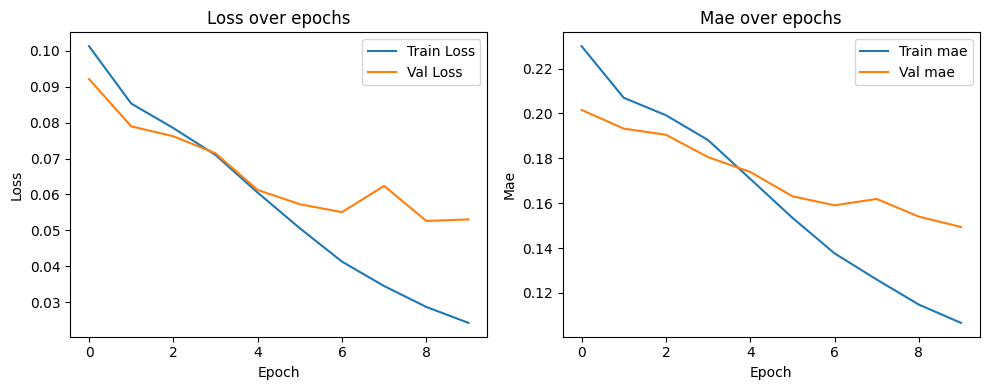

In [85]:
results_df, mse, mae, r2 = evaluate_regression_model(model, [X_enc_test, X_bert_test], y_test)
plot_learning_curves(history, metric='mae')